In [ ]:
# Приступлю к созданию модель Логистической Регресии
# Для начала выведу графики: Облако слов, Количество комментариев по каждому рейтингу
# 
# Далее напишем код нашей модели. 
# Статистика по столбцу: Нравится скорость отработки заявок: 230
# Статистика по столбцу: Нравится качество выполнения заявки: 42
# Статистика по столбцу: Нравится качество работы сотрудников: 144
# Статистика по столбцу: Понравилось выполнение заявки: 102
# Статистика по столбцу: Вопрос решен: 236
# Статистика по столбцу: Другое: 35
#
# PS: По данной статистики могу сразу сказать что мало данных сразу в 2 категориях: 
# Статистика по столбцу: Нравится качество выполнения заявки: 42
# Статистика по столбцу: Другое: 35
# С большой вероятностью моя модель будет недообученная или переобученная

In [ ]:
# Вывод графика "Облако слов" (отображение самых популярных слов в комментариях)

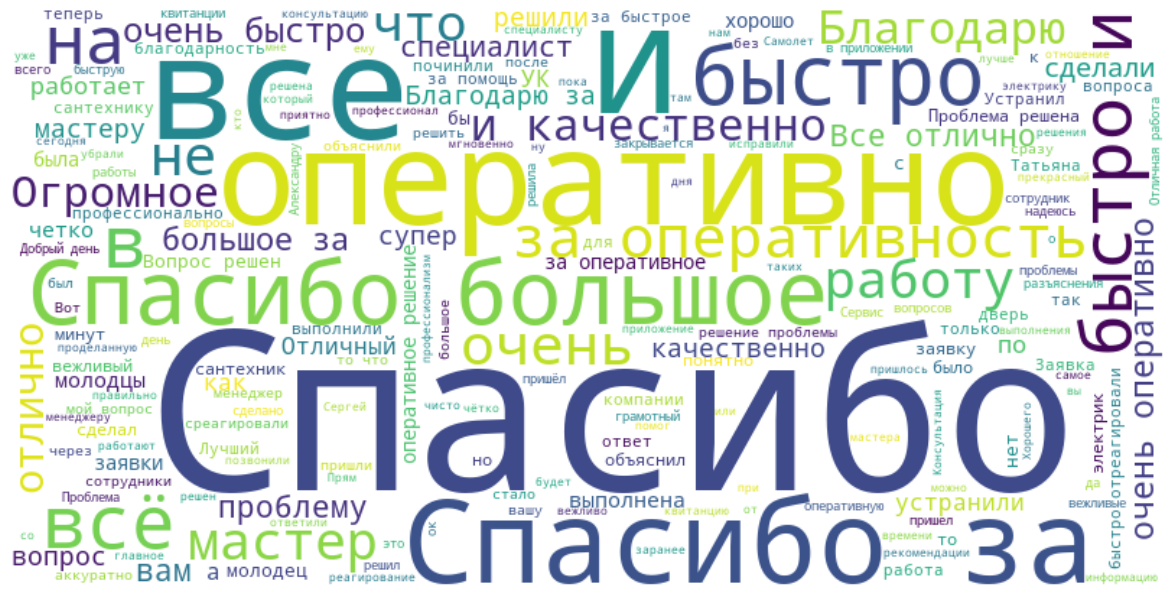

In [12]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('comments_processed_time.csv')

comments = df['comment'].dropna().astype(str)
text = ' '.join(comments)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Вывод графика "Количество комментариев по каждому рейтингу" (на нём будет отображаться количество комментариев по каждому рейтину от 1 до 5)

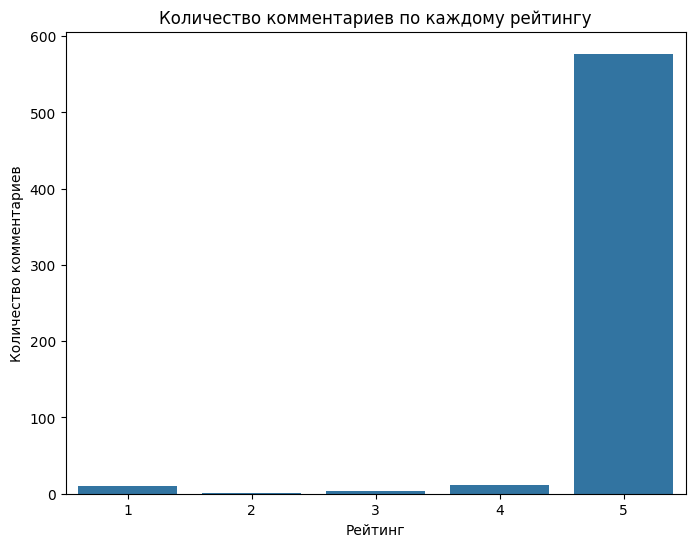

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('comments_processed_time.csv')

if 'rating' in df.columns:
    rating_counts = df['rating'].value_counts().sort_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=rating_counts.index.astype(str), y=rating_counts.values)
    plt.title('Количество комментариев по каждому рейтингу')
    plt.xlabel('Рейтинг')
    plt.ylabel('Количество комментариев')
    plt.show()

In [ ]:
# Подгружаю библиотки для создания модели Логистической Регрессии
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, precision_score
import joblib

# Загрузка данных
df = pd.read_csv('comments_processed_time.csv')

# Список всех котегорий
categories = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Другое'
]

comments = df['comment'].astype(str)

# Перед началом делаю простую функцию токенизации
def tokenize_text(text):
    return ' '.join(text.lower().split())

comments_tokenized = comments.apply(tokenize_text)

# Делаю векторизацию
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments_tokenized)

# Проверяю наличие колонок с категориями
for cat in categories:
    if cat not in df.columns:
        print(f"Колонка '{cat}' не найдена в данных. Проверьте названия и структуру файла.")
        exit()

# Обучаю модель для каждой категории
models = {}
metrics_results = {}

for category in categories:
    y = df[category]
    # Проверяю, есть ли хотя бы один положительный пример
    if y.sum() == 0:
        print(f"В категории '{category}' нет положительных примеров. Обучение невозможно.")
        continue
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    models[category] = model

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics_results[category] = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'precision': precision_score(y_test, y_pred)
    }

# Объединяю все объекты в один словарь для сохранения
model_package = {
    'models': models,
    'vectorizer': vectorizer,
    'categories': categories
}

# Сохраню всё в один файл
joblib.dump(model_package, 'model.pth')

# Сделаю вывод оценки каждой метрики по категориям
print("Метрики моделей по категориям:")
for category, metrics in metrics_results.items():
    print(f"Категория: {category}")
    print(f"  ROC AUC: {metrics['roc_auc']:.3f}")
    print(f"  Accuracy: {metrics['accuracy']:.3f}")
    print(f"  Recall: {metrics['recall']:.3f}")
    print(f"  F1 Macro: {metrics['f1_macro']:.3f}")
    print(f"  Precision: {metrics['precision']:.3f}")
    print("-" * 50)

# Сделаем поле для ввода пользовательского комментария
while True:
    print("\nВведите комментарий для предсказания (или напишите 'выход' для завершения):")
    user_input = input()
    if user_input.strip().lower() == 'выход':
        break

    comment_tok = tokenize_text(user_input)
    comment_vec = vectorizer.transform([comment_tok])

    predicted_probs = {}
    for category in categories:
        model = models.get(category)
        if model:
            proba = model.predict_proba(comment_vec)[0][1]
            predicted_probs[category] = proba

    if predicted_probs:
        predicted_category = max(predicted_probs, key=predicted_probs.get)
        confidence = predicted_probs[predicted_category]
        print(f"\nКомментарий: {user_input}")
        print(f"Предполагаемая категория: {predicted_category} (уверенность: {confidence:.2f})")
    else:
        print("Нет доступных моделей для предсказания.")

Метрики моделей по категориям:
Категория: Нравится скорость отработки заявок
  ROC AUC: 0.955
  Accuracy: 0.893
  Recall: 0.913
  F1 Macro: 0.888
  Precision: 0.824
--------------------------------------------------
Категория: Нравится качество выполнения заявки
  ROC AUC: 0.918
  Accuracy: 0.959
  Recall: 0.500
  F1 Macro: 0.797
  Precision: 0.800
--------------------------------------------------
Категория: Нравится качество работы сотрудников
  ROC AUC: 0.787
  Accuracy: 0.843
  Recall: 0.379
  F1 Macro: 0.721
  Precision: 0.917
--------------------------------------------------
Категория: Понравилось выполнение заявки
  ROC AUC: 0.789
  Accuracy: 0.826
  Recall: 0.000
  F1 Macro: 0.452
  Precision: 0.000
--------------------------------------------------
Категория: Вопрос решен
  ROC AUC: 0.914
  Accuracy: 0.851
  Recall: 0.766
  F1 Macro: 0.841
  Precision: 0.837
--------------------------------------------------
Категория: Другое
  ROC AUC: 0.748
  Accuracy: 0.950
  Recall: 0.143